정확도, 정밀도, 재현율을 넘어서 모델의 성능을 보다 깊게 이해하기 위해 다른 평가 방법을 적용한다.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import joblib

import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author,
    add_text_features_to_df,
    get_vectorized_series,
    get_feature_vector_and_label,
)
from ml_editor.model_evaluation import get_confusion_matrix_plot, get_roc_plot, get_calibration_plot

data_path = Path('./data/processed/writers/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


특성 추가, 데이터셋 분할

In [7]:
df = add_text_features_to_df(df.loc[df["is_question"]].copy())
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

훈련된 모델, 벡터화 객체를 로드한다.

In [9]:
model_path = Path("./models/model_1.pkl")
clf = joblib.load(model_path) 
vectorizer_path = Path("./models/vectorizer_1.pkl")
vectorizer = joblib.load(vectorizer_path) 

벡터화 객체를 사용해 데이터에서 모델에 필요한 특성을 만듭니다.

In [12]:
train_df["vectors"] = get_vectorized_series(train_df["full_text"].copy(), vectorizer)
test_df["vectors"] = get_vectorized_series(test_df["full_text"].copy(), vectorizer)

features = [
                "action_verb_full",
                "question_mark_full",
                "text_len",
                "language_question",
            ]
X_train, y_train = get_feature_vector_and_label(train_df, features)
X_test, y_test = get_feature_vector_and_label(test_df, features)

모델 예측 계산

In [13]:
y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

# 오차 행렬

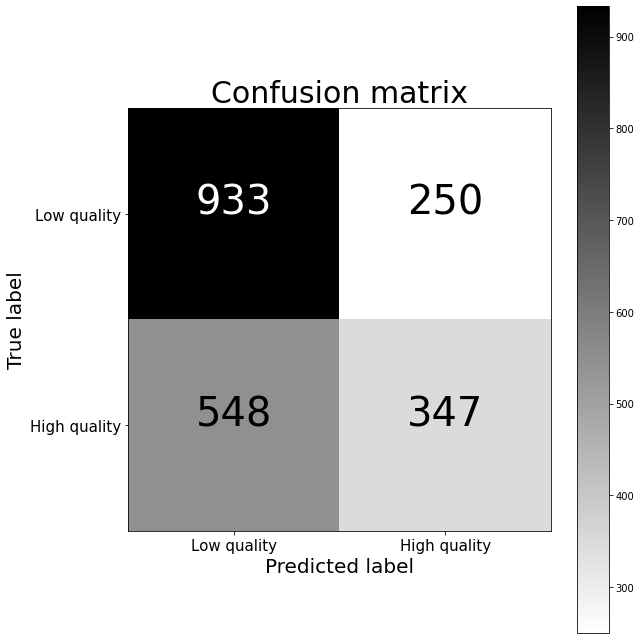

In [14]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))
plt.show()

오차 행렬을 보면 모델이 낮은 점수의 질문을 예측하는데 보다 잘 작동하는 것을 확인할 수 있다. (낮은 점수에 대한 재현율이 높다.)
- 낮은 점수의 재현율: 933 / (933 + 250) = 78.8%
- 높은 점수의 재현율: 548 / (548 + 347) = 61%

# ROC 곡선

모델의 진짜 양성 비율을 거짓 양성 비율의 함수로 보여준다.

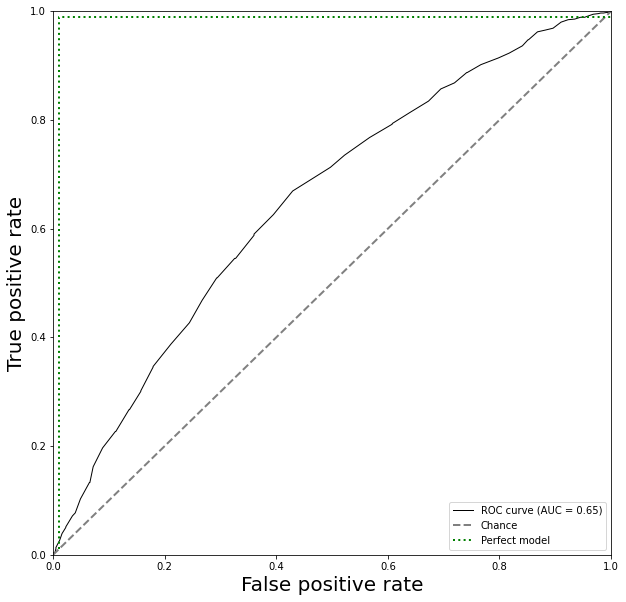

In [22]:
get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))
plt.savefig('./images/bmlpa_figures/ROC.png', dpi=300)
plt.show()

ROC 곡선은 모델의 전반적인 성능을 판단하는데 도움이 된다.    
대부분의 모델은 실용적인 애플리케이션을 염두에 두고 설계되기 때문에 거짓 양성 비율이 특정 비율 아래롤 유지되는 것 같이 특정 성능 요구사항이 뒤따른다.     
따라서 아래 그림처럼 ROC 곡선의 관련 부분을 시각적으로 부각시키면 좋다.

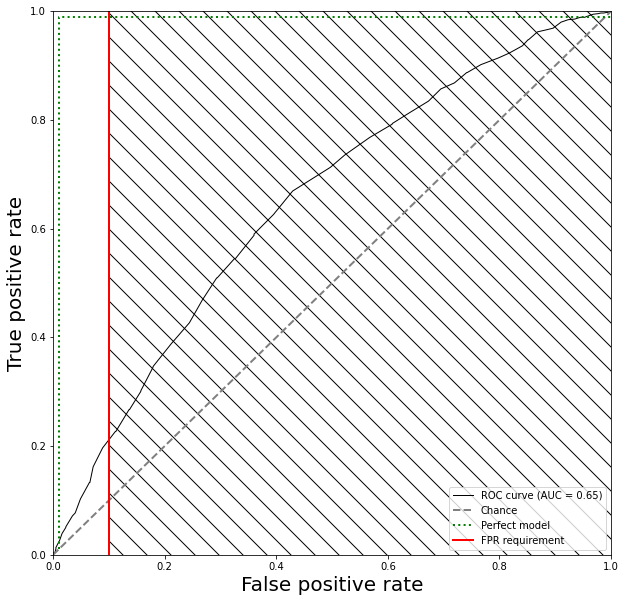

In [23]:
get_roc_plot(y_predicted_proba[:,1], y_test, fpr_bar=.1, figsize=(10,10))
plt.savefig('./images/bmlpa_figures/ROC_with_threshhold.png', dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


	Brier: 0.230


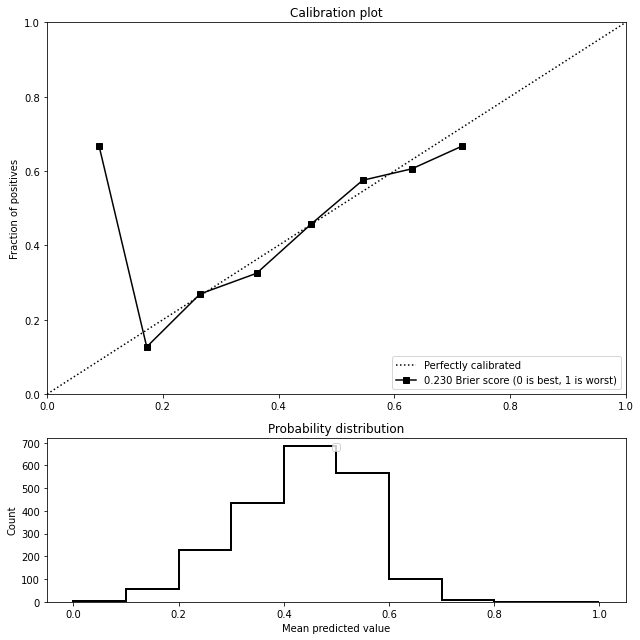

In [27]:
get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))
plt.savefig('./images/bmlpa_figures/ch05-9.png', dpi=300)

위의 보정 곡선을 통해 0.2~07 사이에서 모델이 잘 보정되었고 그 밖에서는 나쁜 것을 확인할 수 있다.     
이는 히스토그램을 통해 부분적으로 모델의 대부분의 예측 값이 0.2~0.7의 점수를 예측하기 떄문으로 볼 수 있다.(샘플 하나하나의 값이 비율에 주는 영향이 적다.)
브라이어 값은 예측값과 실제 레이블 사이의 MSE 값이며 0 일수록 좋다.